In [223]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import glorot_uniform
import matplotlib.pyplot as plt

In [224]:
# Extract data
route = 20
station = 17
data = pd.read_csv("Data/Cleaned_data.csv")
y = data[(data['visualiseringskode'] == route) & (data['station'] == station)]['togpunktlighed'].values
X = data[(data['visualiseringskode'] == route) & (data['station'] == station)].iloc[:,2:]

# Shift
y = y[4:]
X = X.iloc[:-4, :]
#print(y.shape, X.shape)

In [225]:
# Data prep
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
#X_scaled = X_scaled.reshape(2553,1,211)
# Split data into train and test sets
X_train, X_test, y_train, y_test_GBDT = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)



In [226]:
import xgboost as xgb
boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', n_estimators = 100, steps=20, learning_rate=0.05, max_depth=8) 
boosted_model.fit(X_train, y_train)
y_pred_GBDT = boosted_model.predict(X_test)

In [227]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

time_steps = 3

# Create sequences
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# Split data into train and test sets
X_train, X_test, y_train, y_test_LSTM = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [228]:
# Seeds
import random
import tensorflow as tf
random.seed(21)
tf.random.set_seed(21)

In [229]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, X_seq.shape[2]), kernel_initializer=glorot_uniform(seed=22)))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_LSTM = model.predict(X_test)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1348 - val_loss: 0.0130
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0114
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0110
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0107
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0107
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_lo

In [230]:
from sklearn.metrics import mean_absolute_error
mae_GBDT = mean_absolute_error(y_test_GBDT, y_pred_GBDT)
mae_LSTM = mean_absolute_error(y_test_LSTM, y_pred_LSTM)
print(f'Mean Absolute Error (GBDT): {mae_GBDT}')
print(f'Mean Absolute Error (LSTM): {mae_LSTM}')

Mean Absolute Error (GBDT): 0.08763016643542834
Mean Absolute Error (LSTM): 0.0678024544024


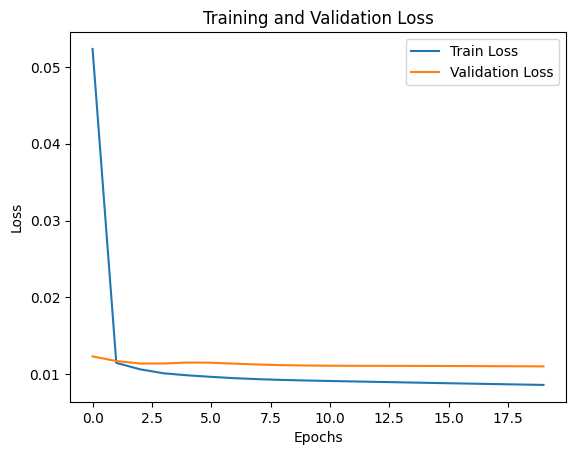

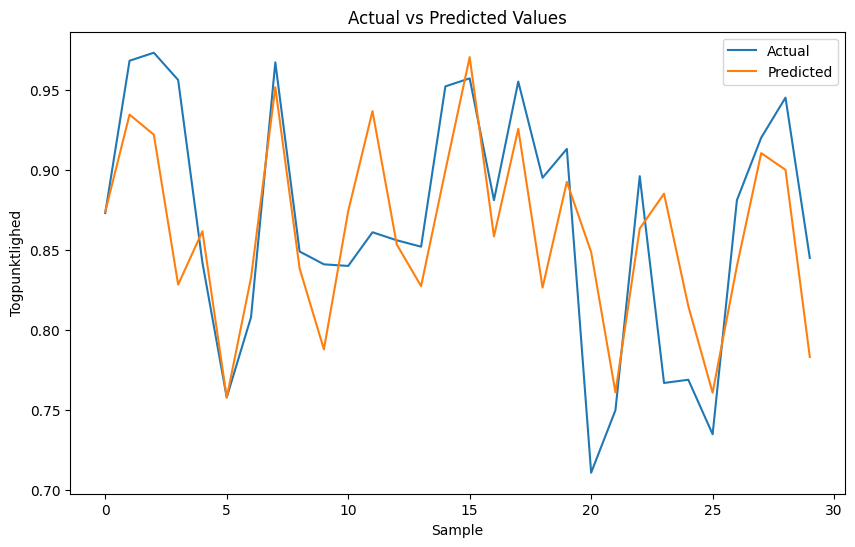

In [220]:
# Plot results
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_LSTM[-30:], label='Actual')
plt.plot(y_pred_LSTM[-30:], label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Togpunktlighed')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [9]:
# True code for thinlinc
from pmdarima.model_selection import RollingForecastCV
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential


warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_LSTM(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			train_available = train[:-(i-1) if i > 1 else None]
			baseline = [np.mean(y[train_available])] * len(y[test])

			print(f'NAN X:{np.sum(np.isnan(X))}')
			print(np.sum(np.isnan(y)))
			
			LSTM_model = estimator_tuple
			# Fit ARIMA model
			LSTM_model.fit(X[train_available], y[train_available], epochs=20, batch_size=32, validation_split=0.2)
			
			preds = LSTM_model.predict(X[test])
			overall_pred = np.clip(preds, 0,1) # make sure it is in [0;1]

			return overall_pred, test, baseline
		
		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		for i, (pred_block, test_indices, baseline) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			y_true += y[test_indices]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(1):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(horizon)] = y[test][i]
				fold_dict['Predictions_baseline{}'.format(horizon)] = baseline_pred[fold][i]
				fold_dict['Predictions_full{}'.format(horizon)] = fold_predictions[i]
				fold_dict['CV_score_full{}'.format(horizon)] = fold_score
				fold_dict['CV_score_baseline{}'.format(horizon)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(1):
			result_df['Error_full{}'.format(horizon)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]
			
		return result_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,2:]
	
	full_result_df = pd.DataFrame()

	for i in range(1,5): # the shifts
		y = y[i:]
		X = X.iloc[:-i,:]
		scaler = MinMaxScaler(feature_range=(0, 1))
		X_scaled = scaler.fit_transform(X)
		time_steps = 7
		# Create sequences
		def create_sequences(X, y, time_steps):
			X_seq, y_seq = [], []
			for i in range(len(X) - time_steps):
				X_temp = X[i:i + time_steps]
				y_temp = y[i + time_steps]
				if not np.isnan(X_temp).any() and not np.isnan(y_temp):
					X_seq.append(X_temp)
					y_seq.append(y_temp)
			return np.array(X_seq), np.array(y_seq)

		X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

        # Define models
		model_name = 'LSTM'
		LSTM_model = Sequential()
		LSTM_model.add(Input(shape=(time_steps, X_seq.shape[2])))
		LSTM_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, X_seq.shape[2])))
		LSTM_model.add(Dense(1))  # Output layer for regression

		# Compile the model
		
		LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        # Expanding Window CV
		print('Initialize Expanding Window CV')
		initial_start = y_seq.shape[0] - no_preds
		result_df = custom_cross_val_predict_LSTM(LSTM_model, y_seq, X_seq, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=i)
		full_result_df = pd.concat([full_result_df, result_df], axis=1)

	full_result_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]), horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=2, data_name='Cleaned_lagged')

Initialize Expanding Window CV
Fold 0
NAN X:0
0
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2118 - val_loss: 0.0114
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0100
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0105
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0100
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0102
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 12/20
64/64 ━━━━━━━━

KeyboardInterrupt: 

In [84]:
results = pd.read_csv("Results/Shifted_Runs/Cleaned_lagged/LSTM/(20, 19)_Boosted0_results365.csv")
results

,y_true1,Predictions_baseline1,Predictions_full1,CV_score_full1,CV_score_baseline1,Error_full1,Error_baseline1,y_true2,Predictions_baseline2,Predictions_full2,...,CV_score_baseline3,Error_full3,Error_baseline3,y_true4,Predictions_baseline4,Predictions_full4,CV_score_full4,CV_score_baseline4,Error_full4,Error_baseline4
0,0.865,0.829953,0.987619,0.122619,0.035047,0.09399,0.081968,0.865,0.830008,1.000000,...,0.034900,0.104742,0.08201,0.865,0.830208,1.000000,0.135000,0.034792,0.139794,0.082049
1,0.857,0.829969,0.986695,0.129695,0.027031,0.09399,0.081968,0.857,0.829975,0.999637,...,0.026936,0.104742,0.08201,0.857,0.830201,1.000000,0.143000,0.026799,0.139794,0.082049
2,0.744,0.829982,0.921149,0.177149,0.085982,0.09399,0.081968,0.744,0.829991,1.000000,...,0.086031,0.104742,0.08201,0.744,0.830165,1.000000,0.256000,0.086165,0.139794,0.082049
3,0.798,0.829942,0.817065,0.019065,0.031942,0.09399,0.081968,0.798,0.830003,0.932279,...,0.032047,0.104742,0.08201,0.798,0.830131,1.000000,0.202000,0.032131,0.139794,0.082049
4,0.723,0.829928,0.783711,0.060711,0.106928,0.09399,0.081968,0.723,0.829964,0.849563,...,0.107059,0.104742,0.08201,0.723,0.830147,1.000000,0.277000,0.107147,0.139794,0.082049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.674,0.822577,0.826099,0.152099,0.148577,0.09399,0.081968,0.674,0.822543,0.787502,...,0.148542,0.104742,0.08201,0.674,0.822577,0.918790,0.244790,0.148577,0.139794,0.082049
361,0.849,0.822519,0.905799,0.056799,0.026481,0.09399,0.081968,0.849,0.822590,0.784933,...,0.026418,0.104742,0.08201,0.849,0.822616,0.909662,0.060662,0.026384,0.139794,0.082049
362,0.888,0.822529,0.778547,0.109453,0.065471,0.09399,0.081968,0.888,0.822531,0.901079,...,0.065371,0.104742,0.08201,0.888,0.822657,0.935707,0.047707,0.065343,0.139794,0.082049
363,0.900,0.822555,0.782455,0.117545,0.077445,0.09399,0.081968,0.900,0.822542,0.903556,...,0.077429,0.104742,0.08201,0.900,0.822704,0.819915,0.080085,0.077296,0.139794,0.082049


In [85]:
np.mean(results['CV_score_full1'])

0.09398992296636917

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler
import shap
time_steps=7
#rom tensorflow.compat.v1.keras.backend import get_session
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.enable_v2_behavior()
# Your model definition
model = Sequential()
model.add(Input(shape=(time_steps, X_seq.shape[2])))
model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, X_seq.shape[2])))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.build(input_shape=(None, time_steps, X_seq.shape[2]))
model.fit(X_seq, y_seq, epochs=5, batch_size=32, validation_split=0.2)
			
preds = model.predict(X_seq)
overall_pred = np.clip(preds, 0,1) # make sure it is in [0;1]
model(tf.keras.Input((time_steps, X_seq.shape[2])))
model_output = model.output
# SHAP values
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.KernelExplainer(model, np.array(X_seq[:100]))
explanation = explainer(X_seq)


# Ensure your model's output is a tensor, not a tuple
model_output = model.output


Epoch 1/5


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Tensorflow3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1698 - val_loss: 0.0257
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0258
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0247
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0221
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0249
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


DimensionError: Instance must have 1 or 2 dimensions!

In [1]:
import tensorflow as tf

# Step 1: Clear the TensorFlow session
tf.keras.backend.clear_session()

# Step 2: Manually re-import TensorFlow to reset its state
import sys
import importlib


In [88]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,355 (614.67 KB)

 Trainable params: 52,451 (204.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,904 (409.79 KB)

In [91]:
print(type(model.output), model.output)
print(type(X_seq[:100]), X_seq[:100].shape)

<class 'keras.src.backend.common.keras_tensor.KerasTensor'> <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_13>
<class 'numpy.ndarray'> (100, 7, 211)


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

# Generate dummy data
# Data prep
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Wrapper function for the LSTM model
def predict(data):
    return model.predict(data).reshape(-1)

# Select a background dataset for SHAP (using a subset of training data)
background = X_train[:50].reshape(50, -1)

# Create an explainer object using the KernelExplainer for LSTM models
explainer = shap.KernelExplainer(predict, background)

# Select a few samples to explain
samples_to_explain = X_train[50:60].reshape(10, -1)

# Compute SHAP values
shap_values = explainer.shap_values(samples_to_explain)

# Plot the SHAP values for the first sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], samples_to_explain[0])
shap.summary_plot(shap_values, samples_to_explain[0])


Epoch 1/10


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Tensorflow3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3804
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0167
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0139
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0146
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0129
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0139
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0140
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0141
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0137
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3672/3672 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3669/3669 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [7]:
X_train.shape

(2042, 211)

In [10]:
data.iloc[:,2:].columns

Index(['visualiseringskode', 'station',
       'koreplan_antal_planlagte_unik_tognr_togpkt_myldretid',
       'koreplan_antal_planlagte_prod_kode_myldretid',
       'koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid',
       'koreplan_antal_planlagte_unik_tognr_alle_myldretid',
       'koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid',
       'koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid',
       'koreplan_antal_planlagte_togfoelge_under_5_min_myldretid',
       'koreplan_gns_planlagte_togfoelg_alle_min_myldretid',
       ...
       'dsb_tgf_relative_sygdom', 'dsb_lkf_fte', 'dsb_lkf_sygdom',
       'dsb_lkf_relative_sygdom', 'dsb_haandvaerker', 'dsb_fravaer',
       'dsb_relative_fravaer', 'mean_temp', 'mean_wind_speed', 'acc_precip'],
      dtype='object', length=211)

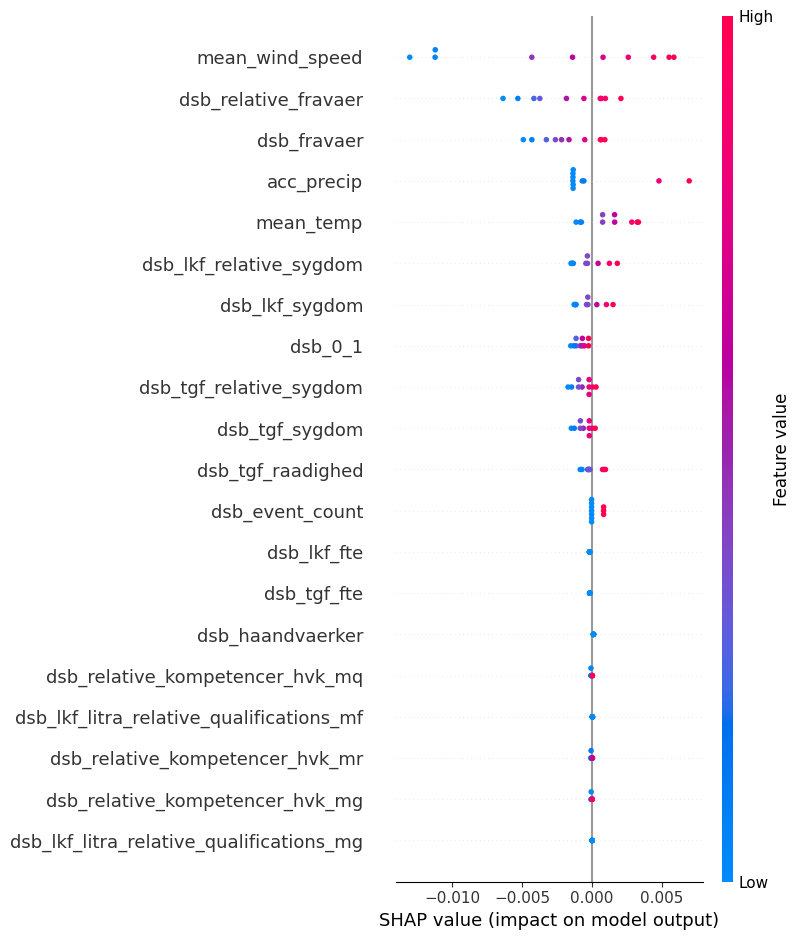

In [13]:
shap.summary_plot(shap_values, samples_to_explain, feature_names=data.iloc[:,2:].columns)


In [23]:
X_train.shape

(2042, 211)

In [27]:
# Select a background dataset for SHAP (using a subset of training data)
background = X_train[:10].reshape(10, -1)

# Create an explainer object using the KernelExplainer for LSTM models
explainer = shap.KernelExplainer(predict, background)

# Select a few samples to explain
samples_to_explain = X_test[:100].reshape(100, -1)

# Compute SHAP values
shap_values = explainer.shap_values(samples_to_explain)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
739/739 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
739/739 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
74

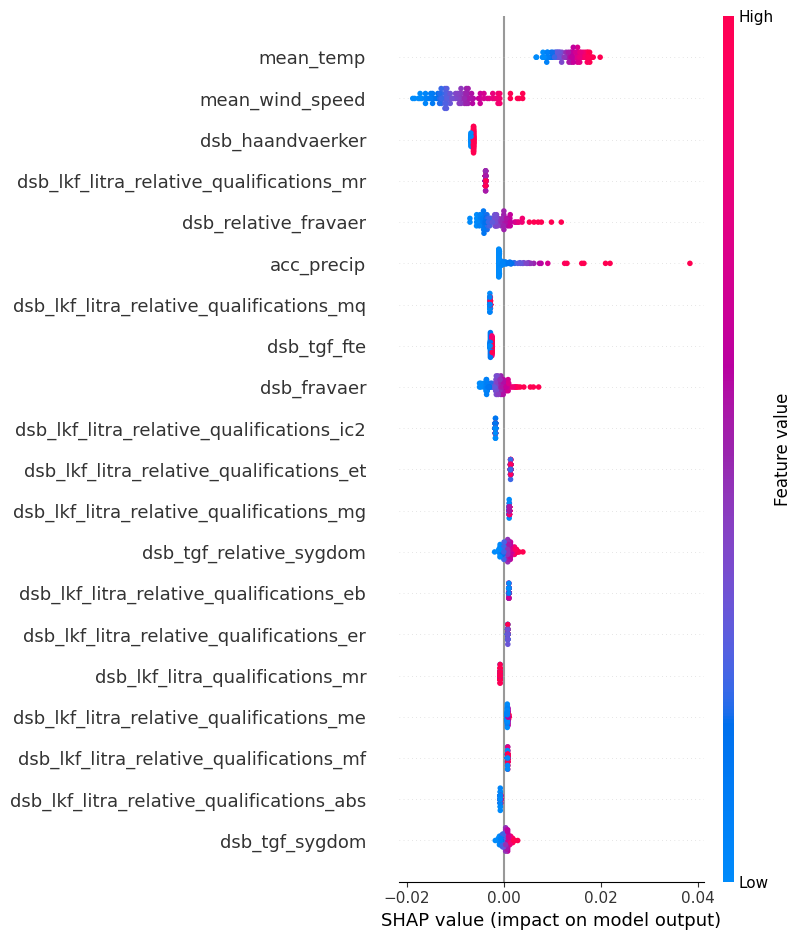

In [28]:
shap.summary_plot(shap_values, samples_to_explain, feature_names=data.iloc[:,2:].columns)

# Moment of utmost panic 

I thought the CV loop implemented across all models was wrong. But the lstm model has to be in the same conditions in the homemade for loop below and then it performs similarly bad.

In [143]:
def cross_validation(test_size, X_seq, y_seq, horizon):
    # Perform rolling window cross-validation
    all_cv_scores = []
    all_pred = []
    all_true_y = []

    for i in range(test_size):
        # Define the training and testing data for the current window
        index = (test_size-i)
        print(index)
        print(index + horizon)
        train_data = X_seq[ :-(index + horizon)]
        test_data = X_seq[[-index]]
        train_labels = y_seq[: -(index + horizon)]
        test_labels = y_seq[[-index]]
        print(test_labels.shape)

        # Train the model
        model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

        # Predict one observation
        y_pred = model.predict(test_data)

        # Evaluate the model
        score = abs(test_labels-y_pred)

        # Save results
        all_cv_scores.append(score)
        all_pred.append(y_pred)
        all_true_y.append(test_labels)
    return all_true_y, all_pred, all_cv_scores


In [ ]:
# Extract data
route = 20
station = 17
data = pd.read_csv("Data/Cleaned_data.csv")
y = data[(data['visualiseringskode'] == route) & (data['station'] == station)]['togpunktlighed'].values
X = data[(data['visualiseringskode'] == route) & (data['station'] == station)].iloc[:,2:]

# Shift
y = y[4:]
X = X.iloc[:-4, :]
#print(y.shape, X.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

time_steps = 7

# Create sequences
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

y_true, pred, cv_score = cross_validation(10, X_seq, y_seq, horizon=4)

In [144]:
y_true

[array([0.889]),
 array([0.764]),
 array([0.918]),
 array([0.956]),
 array([0.941]),
 array([0.717]),
 array([0.788]),
 array([0.906]),
 array([0.949]),
 array([0.891])]

In [146]:
pred

[array([[0.53782105]], dtype=float32),
 array([[0.51025367]], dtype=float32),
 array([[0.5658848]], dtype=float32),
 array([[0.6395206]], dtype=float32),
 array([[0.5534973]], dtype=float32),
 array([[0.5120985]], dtype=float32),
 array([[0.6644464]], dtype=float32),
 array([[0.5884366]], dtype=float32),
 array([[0.533628]], dtype=float32),
 array([[0.5014775]], dtype=float32)]

In [147]:
cv_score

[array([[0.35117895]]),
 array([[0.25374633]]),
 array([[0.35211517]]),
 array([[0.31647941]]),
 array([[0.38750269]]),
 array([[0.20490151]]),
 array([[0.12355359]]),
 array([[0.3175634]]),
 array([[0.41537201]]),
 array([[0.38952252]])]

In [12]:
def custom_cross_val_predict_LSTM(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, no_preds=2, horizon=1):

    # Adjusted function to generate sequences dynamically within each fold
    def generate_sequences(X, y, time_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - time_steps - horizon + 1):  # Adjusted to account for horizon
            X_temp = X[i:i + time_steps]
            y_temp = y[i + time_steps + horizon - 1]  # Adjusted to get target value corresponding to X_temp
            if not np.isnan(X_temp).any() and not np.isnan(y_temp):
                X_seq.append(X_temp)
                y_seq.append(y_temp)
        return np.array(X_seq), np.array(y_seq)

    # Adjusted cross-validation loop
    def fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
        print('Fold {}'.format(fold))
        """Internal utility to fit and predict"""
        train_available = train[:-(i-1) if i > 1 else None]

        X_train, y_train = generate_sequences(X[train_available], y[train_available], time_steps)
        X_test, y_test = generate_sequences(X[test], y[test], time_steps)

        print(f'NAN X_train: {np.sum(np.isnan(X_train))}')
        print(f'NAN y_train: {np.sum(np.isnan(y_train))}')
        print(f'NAN X_test: {np.sum(np.isnan(X_test))}')
        print(f'NAN y_test: {np.sum(np.isnan(y_test))}')

        LSTM_model = estimator_tuple
        # Fit LSTM model
        LSTM_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

        preds = LSTM_model.predict(X_test)
        overall_pred = np.clip(preds, 0, 1)  # make sure it is in [0;1]

        return overall_pred, y_test

    # Other helper functions and checks remain the same

    # Adjusted parts of the main function
    # Initialize result dataframe
    full_result_df = pd.DataFrame()

    for i in range(1, 5):  # the shifts
        y = y[i:]
        X = X.iloc[:-i, :]
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)
        time_steps = 7

        # Define models
        model_name = 'LSTM'
        LSTM_model = Sequential()
        LSTM_model.add(Input(shape=(time_steps, 275)))
        LSTM_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, 275)))
        LSTM_model.add(Dense(1))  # Output layer for regression

        # Compile the model
        LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Expanding Window CV
        print('Initialize Expanding Window CV')
        initial_start = y.shape[0] - no_preds
        result_df = custom_cross_val_predict_LSTM(LSTM_model, y, X_scaled, cv=None, verbose=1, averaging="mean",
                                                  return_raw_predictions=False, initial=initial_start, horizon=i)
        full_result_df = pd.concat([full_result_df, result_df], axis=1)
        return full_result_df
    #full_result_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds),index=False)

full_result_df = HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=2, data_name='Cleaned_lagged')

Initialize Expanding Window CV
Fold 0
NAN X:0
0
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0781 - val_loss: 0.0122
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0131
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0119
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0114
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0127
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0111
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0131
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0113
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 12/20
64/64 ━━━━━━━━

In [37]:
# True code for thinlinc
# WITHOUT TARGET LEAKAGE!
from pmdarima.model_selection import RollingForecastCV
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential


warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_LSTM(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		# Adjusted function to generate sequences dynamically within each fold
		def generate_sequences(X=X, y=y, time_steps=7, index=0):
			X_seq, y_seq = [], []
			for i in range(len(X) - time_steps - horizon + 1):  # Adjusted to account for horizon
				if i==0:
					if index == 0:
						X_temp = X[-time_steps:]
						y_temp = y[-1]
					else:
						X_temp = X[index+1-time_steps:index+1]
						y_temp = y[index]
						return np.array([X_temp]), np.array([y_temp])
					
				else:
					X_temp = X[-(i+time_steps):-i]
					y_temp = y[-i]  # Adjusted to get target value corresponding to X_temp
				if not np.isnan(X_temp).any() and not np.isnan(y_temp):
					X_seq.append(X_temp)
					y_seq.append(y_temp)
			return np.array(X_seq), np.array(y_seq)


		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			train_available = train[:-(i-1) if i > 1 else None]
			baseline = [np.mean(y[train_available])] * len(y[test])

			X_train, y_train = generate_sequences(X[train_available], y[train_available], time_steps)
			X_test, y_test = generate_sequences(index=int(test))

			print(f'NAN X_train: {np.sum(np.isnan(X_train))}')
			print(f'NAN y_train: {np.sum(np.isnan(y_train))}')
			print(f'NAN X_test: {np.sum(np.isnan(X_test))}')
			print(f'NAN y_test: {np.sum(np.isnan(y_test))}')

			LSTM_model = estimator_tuple
			# Fit LSTM model
			LSTM_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

			preds = LSTM_model.predict(X_test)
			overall_pred = np.clip(preds, 0, 1)  # make sure it is in [0;1]

			#return overall_pred, y_test
			return overall_pred, test, baseline
		
		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		for i, (pred_block, test_indices, baseline) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			y_true += y[test_indices]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(1):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(horizon)] = y[test][i]
				fold_dict['Predictions_baseline{}'.format(horizon)] = baseline_pred[fold][i]
				fold_dict['Predictions_full{}'.format(horizon)] = fold_predictions[i]
				fold_dict['CV_score_full{}'.format(horizon)] = fold_score
				fold_dict['CV_score_baseline{}'.format(horizon)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(1):
			result_df['Error_full{}'.format(horizon)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]
			
		return result_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,2:]
	
	full_result_df = pd.DataFrame()

	for i in range(1,5): # the shifts
		y = y[i:]
		X = X.iloc[:-i,:]
		scaler = MinMaxScaler(feature_range=(0, 1))
		X_scaled = scaler.fit_transform(X)
		time_steps = 7
		
        # Define models
		model_name = 'LSTM'
		LSTM_model = Sequential()
		LSTM_model.add(Input(shape=(time_steps, 275)))
		LSTM_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, 275)))
		LSTM_model.add(Dense(1))  # Output layer for regression

		# Compile the model
		
		LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        # Expanding Window CV
		print('Initialize Expanding Window CV')
		initial_start = y.shape[0] - no_preds
		result_df = custom_cross_val_predict_LSTM(LSTM_model, y, X_scaled, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=i)
		full_result_df = pd.concat([full_result_df, result_df], axis=1)

	full_result_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	print('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds))
#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]), horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 0, no_preds=10, data_name='Cleaned_lagged')

Initialize Expanding Window CV
Fold 0
NAN X_train: 0
NAN y_train: 0
NAN X_test: 0
NAN y_test: 0
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1715 - val_loss: 0.0113
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0098
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0094
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0098
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0096
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0090
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00

In [36]:
results = pd.read_csv("Results/Shifted_Runs/Cleaned_lagged/LSTM/(20, 19)_Boosted1_results10.csv")
results

,y_true1,Predictions_baseline1,Predictions_full1,CV_score_full1,CV_score_baseline1,Error_full1,Error_baseline0,y_true2,Predictions_baseline2,Predictions_full2,...,CV_score_baseline3,Error_full3,Error_baseline0.2,y_true4,Predictions_baseline4,Predictions_full4,CV_score_full4,CV_score_baseline4,Error_full4,Error_baseline0.3
0,0.834,0.822624,0.720088,0.113912,0.011376,0.113995,0.078501,0.834,0.822595,0.688331,...,0.011340,0.08904,0.078513,0.834,0.822604,0.735867,0.098133,0.011396,0.09934,0.078572
1,0.760,0.822628,0.871339,0.111339,0.062628,0.113995,0.078501,0.760,0.822587,0.864085,...,0.062606,0.08904,0.078513,0.760,0.822556,0.790474,0.030474,0.062556,0.09934,0.078572
2,0.921,0.822604,0.787413,0.133587,0.098396,0.113995,0.078501,0.921,0.822591,0.959263,...,0.098403,0.08904,0.078513,0.921,0.822502,0.805633,0.115367,0.098498,0.09934,0.078572
3,0.926,0.822642,0.798820,0.127180,0.103358,0.113995,0.078501,0.926,0.822567,0.744938,...,0.103398,0.08904,0.078513,0.926,0.822494,0.716042,0.209958,0.103506,0.09934,0.078572
4,0.941,0.822683,0.850431,0.090569,0.118317,0.113995,0.078501,0.941,0.822605,0.669996,...,0.118423,0.08904,0.078513,0.941,0.822498,0.714599,0.226401,0.118502,0.09934,0.078572
5,0.674,0.822729,0.921286,0.247286,0.148729,0.113995,0.078501,0.674,0.822646,0.856990,...,0.148616,0.08904,0.078513,0.674,0.822474,0.683796,0.009796,0.148474,0.09934,0.078572
6,0.849,0.822671,0.692320,0.156680,0.026329,0.113995,0.078501,0.849,0.822692,0.872903,...,0.026343,0.08904,0.078513,0.849,0.822513,0.769800,0.079200,0.026487,0.09934,0.078572
7,0.888,0.822681,0.836426,0.051574,0.065319,0.113995,0.078501,0.888,0.822634,0.761755,...,0.065297,0.08904,0.078513,0.888,0.822553,0.768085,0.119915,0.065447,0.09934,0.078572
8,0.900,0.822707,0.841134,0.058866,0.077293,0.113995,0.078501,0.900,0.822644,0.981241,...,0.077355,0.08904,0.078513,0.900,0.822600,0.978738,0.078738,0.077400,0.09934,0.078572
9,0.896,0.822737,0.944959,0.048959,0.073263,0.113995,0.078501,0.896,0.822670,0.906740,...,0.073345,0.08904,0.078513,0.896,0.822541,0.870583,0.025417,0.073459,0.09934,0.078572


In [ ]:
# THINLINC LSTM WITH TARGET LEAKAGE
# True code for thinlinc
from pmdarima.model_selection import RollingForecastCV
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import warnings
from tensorflow.keras.optimizers import Adam
import sys
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_LSTM(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			train_available = train[:-(i-1) if i > 1 else None]
			baseline = [np.mean(y[train_available])] * len(y[test])

			print(f'NAN X:{np.sum(np.isnan(X))}')
			print(np.sum(np.isnan(y)))
			
			LSTM_model = estimator_tuple
			# Fit ARIMA model
			LSTM_model.fit(X[train_available], y[train_available], epochs=20, batch_size=32, validation_split=0.2)
			
			preds = LSTM_model.predict(X[test])
			overall_pred = np.clip(preds, 0,1) # make sure it is in [0;1]

			return overall_pred, test, baseline
		
		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		for i, (pred_block, test_indices, baseline) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			y_true += y[test_indices]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(1):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(horizon)] = y[test][i]
				fold_dict['Predictions_baseline{}'.format(horizon)] = baseline_pred[fold][i]
				fold_dict['Predictions_full{}'.format(horizon)] = fold_predictions[i]
				fold_dict['CV_score_full{}'.format(horizon)] = fold_score
				fold_dict['CV_score_baseline{}'.format(horizon)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(1):
			result_df['Error_full{}'.format(horizon)] = full_score[i]
			result_df['Error_baseline{}'.format(horizon)] = baseline_score[i]
			
		return result_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,2:]
	
	full_result_df = pd.DataFrame()

	for i in range(1,5): # the shifts
		y = y[i:]
		X = X.iloc[:-i,:]
		scaler = MinMaxScaler(feature_range=(0, 1))
		X_scaled = scaler.fit_transform(X)
		time_steps = 7
		# Create sequences
		def create_sequences(X, y, time_steps):
			X_seq, y_seq = [], []
			for i in range(len(X) - time_steps):
				X_temp = X[i:i + time_steps]
				y_temp = y[i + time_steps]
				if not np.isnan(X_temp).any() and not np.isnan(y_temp):
					X_seq.append(X_temp)
					y_seq.append(y_temp)
			return np.array(X_seq), np.array(y_seq)

		X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

        # Define models
		model_name = 'LSTM'
		LSTM_model = Sequential()
		LSTM_model.add(Input(shape=(time_steps, X_seq.shape[2])))
		LSTM_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, X_seq.shape[2])))
		LSTM_model.add(Dense(1))  # Output layer for regression

		# Compile the model
		
		LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        # Expanding Window CV
		print('Initialize Expanding Window CV')
		initial_start = y_seq.shape[0] - no_preds
		result_df = custom_cross_val_predict_LSTM(LSTM_model, y_seq, X_seq, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=i)
		full_result_df = pd.concat([full_result_df, result_df], axis=1)

	full_result_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5])
#HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=2, data_name='Cleaned_lagged')